In [ ]:
!pip install torcheval

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from copy import deepcopy
from math import sqrt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Loading

In [3]:
df = pd.read_csv("/kaggle/input/facial-keypoints-detection/training.zip")

In [4]:
df.head(2)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


# Data Analysis

In [5]:
# Check number of null values for each columm

for col in df.columns:
    num_nan = df[col].isna().sum()
    print(f"{col} : {num_nan} null values")



left_eye_center_x : 10 null values
left_eye_center_y : 10 null values
right_eye_center_x : 13 null values
right_eye_center_y : 13 null values
left_eye_inner_corner_x : 4778 null values
left_eye_inner_corner_y : 4778 null values
left_eye_outer_corner_x : 4782 null values
left_eye_outer_corner_y : 4782 null values
right_eye_inner_corner_x : 4781 null values
right_eye_inner_corner_y : 4781 null values
right_eye_outer_corner_x : 4781 null values
right_eye_outer_corner_y : 4781 null values
left_eyebrow_inner_end_x : 4779 null values
left_eyebrow_inner_end_y : 4779 null values
left_eyebrow_outer_end_x : 4824 null values
left_eyebrow_outer_end_y : 4824 null values
right_eyebrow_inner_end_x : 4779 null values
right_eyebrow_inner_end_y : 4779 null values
right_eyebrow_outer_end_x : 4813 null values
right_eyebrow_outer_end_y : 4813 null values
nose_tip_x : 0 null values
nose_tip_y : 0 null values
mouth_left_corner_x : 4780 null values
mouth_left_corner_y : 4780 null values
mouth_right_corner_x :

In [6]:
#Number of missing values per row
df.isnull().sum(axis=1).value_counts()

22    4755
0     2140
2       87
4       28
24      10
6        9
8        8
12       5
10       3
14       2
20       2
Name: count, dtype: int64

How to deal with missing values?

Assign the -1 number. During training, when the model makes a prediction for an image with label -1, the predicition will be set to -1, in order to not influence on the update.


In [7]:
# Check ranges of variables
df.describe().loc['min'] 


left_eye_center_x            22.763345
left_eye_center_y             1.616512
right_eye_center_x            0.686592
right_eye_center_y            4.091264
left_eye_inner_corner_x      19.064954
left_eye_inner_corner_y      27.190098
left_eye_outer_corner_x      27.571879
left_eye_outer_corner_y      26.250023
right_eye_inner_corner_x      5.751046
right_eye_inner_corner_y     26.250023
right_eye_outer_corner_x      3.980117
right_eye_outer_corner_y     25.123828
left_eyebrow_inner_end_x     17.888717
left_eyebrow_inner_end_y     15.859361
left_eyebrow_outer_end_x     32.206432
left_eyebrow_outer_end_y     10.522325
right_eyebrow_inner_end_x     6.921014
right_eyebrow_inner_end_y    16.476000
right_eyebrow_outer_end_x     3.826243
right_eyebrow_outer_end_y    13.224453
nose_tip_x                   12.944699
nose_tip_y                   17.932414
mouth_left_corner_x          22.923362
mouth_left_corner_y          57.023258
mouth_right_corner_x          2.245766
mouth_right_corner_y     

In [8]:
df.describe().loc['max'] 


left_eye_center_x            94.689280
left_eye_center_y            80.502649
right_eye_center_x           85.039381
right_eye_center_y           81.270911
left_eye_inner_corner_x      84.440991
left_eye_inner_corner_y      66.562559
left_eye_outer_corner_x      95.258090
left_eye_outer_corner_y      64.618230
right_eye_inner_corner_x     70.714966
right_eye_inner_corner_y     69.808803
right_eye_outer_corner_x     61.428580
right_eye_outer_corner_y     70.746797
left_eyebrow_inner_end_x     79.787831
left_eyebrow_inner_end_y     60.875896
left_eyebrow_outer_end_x     94.269957
left_eyebrow_outer_end_y     60.500298
right_eyebrow_inner_end_x    76.582388
right_eyebrow_inner_end_y    62.083177
right_eyebrow_outer_end_x    58.418216
right_eyebrow_outer_end_y    66.751329
nose_tip_x                   89.438592
nose_tip_y                   95.935644
mouth_left_corner_x          84.767123
mouth_left_corner_y          94.673637
mouth_right_corner_x         74.017993
mouth_right_corner_y     

In [9]:
# Impute missing coordinates with -1

df_imputed = deepcopy(df)

df_imputed = df.fillna(-1)


for col in df_imputed.columns:
    num_nan = df_imputed[col].isna().sum()
    print(f"{col} : {num_nan} null values")

left_eye_center_x : 0 null values
left_eye_center_y : 0 null values
right_eye_center_x : 0 null values
right_eye_center_y : 0 null values
left_eye_inner_corner_x : 0 null values
left_eye_inner_corner_y : 0 null values
left_eye_outer_corner_x : 0 null values
left_eye_outer_corner_y : 0 null values
right_eye_inner_corner_x : 0 null values
right_eye_inner_corner_y : 0 null values
right_eye_outer_corner_x : 0 null values
right_eye_outer_corner_y : 0 null values
left_eyebrow_inner_end_x : 0 null values
left_eyebrow_inner_end_y : 0 null values
left_eyebrow_outer_end_x : 0 null values
left_eyebrow_outer_end_y : 0 null values
right_eyebrow_inner_end_x : 0 null values
right_eyebrow_inner_end_y : 0 null values
right_eyebrow_outer_end_x : 0 null values
right_eyebrow_outer_end_y : 0 null values
nose_tip_x : 0 null values
nose_tip_y : 0 null values
mouth_left_corner_x : 0 null values
mouth_left_corner_y : 0 null values
mouth_right_corner_x : 0 null values
mouth_right_corner_y : 0 null values
mouth_

# Visualization

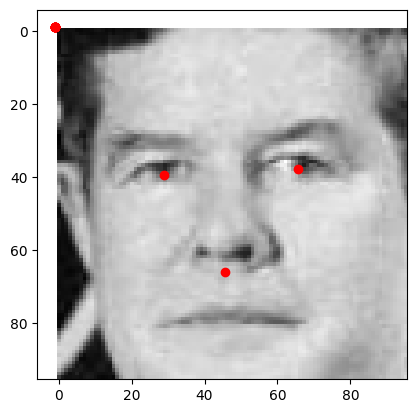

In [10]:
idx = 4000
Image = np.array(df_imputed.iloc[idx,30].split()).astype(np.float32).reshape(96,96)
#image = np.array(df_imputed.iloc[1,30].split()).astype(np.float32)


plt.imshow(Image, cmap='gray')


for i in range(0,28,2):
    plt.scatter(df_imputed.iloc[idx,i],df_imputed.iloc[idx,i+1],c = "r")


# Dataset Creation

In [11]:
from torch.utils.data import Dataset
import pathlib
from typing import Tuple
from PIL import Image as im


class DatasetGenerator(Dataset):
    
    def __init__(self, input_df: pd.DataFrame, train= True, transform=None) -> None:
        
        #Create class attributes
        # Setup transforms
        super().__init__()
        self.transform = transform
        # df with info
        self.input_df = input_df
        
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return self.input_df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        image = np.array(self.input_df.iloc[index, 30].split()).astype(np.float32)#.reshape(96,96)
        image = np.repeat(image.reshape(96, 96, 1), 3, 2).astype(np.uint8) # Reshape to have correct shaper for image, and repeat to simulate 3 color channels
        #since it will be used with a model pretrained on colored images
        #image = im.fromarray(image)
        
        labels = np.array(self.input_df.iloc[index,:30].tolist()).astype(np.float32)
        
        labels[np.isnan(labels)] = -1
        ignore_indices = labels == -1
        labels = labels.reshape(15, 2)

        
        if self.transform:
            augmentations = self.transform(image=image, keypoints=labels)
            image = augmentations["image"]
            labels = augmentations["keypoints"]

        labels = np.array(labels).reshape(-1)
        labels[ignore_indices] = -1
        
        
        return image, labels # return data, label (X, y)


In [12]:
def my_train_test_split(total_df: pd.DataFrame, split_proportion: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    """Function to split the dataset in training and test according to a given proportion between 0 and 1   
    """
    
    train_df = total_df.sample(frac = split_proportion)
    test_df = total_df.drop(train_df.index)
    
    return train_df, test_df

In [13]:
df_train, df_val = my_train_test_split(df, 0.7)

In [14]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Data augmentation for images
train_transforms = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [16]:
train_dataset = DatasetGenerator(df_train, transform= train_transforms)
val_dataset = DatasetGenerator(df_val, transform= train_transforms)

torch.Size([3, 224, 224])


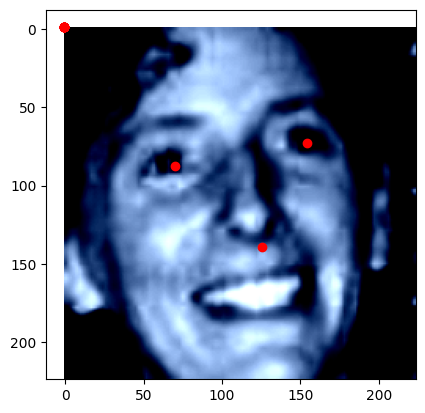

In [17]:
img,label = train_dataset[2]

#plt.imshow(img, cmap= 'gray')


plt.imshow(img.permute(1, 2, 0), cmap= 'gray')
#img
print(img.shape)

for i in range(0,28,2):
    plt.scatter(label[i],label[i+1],c = "r")

In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

torch.Size([64, 3, 224, 224])


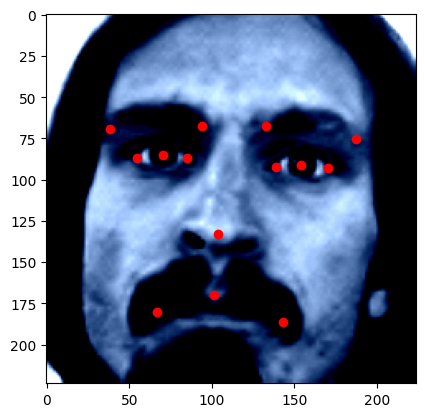

In [19]:
for idx, (X,y) in enumerate(val_dataloader):
    print(X.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    for i in range(0,28,2):
        plt.scatter(y[0,i],y[0,i+1],c = "r")
    break


Dataloader functioning correctly.

# Model download

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s] 


In [21]:
import torchinfo

torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [22]:
#Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
#Substitute last layer for my specific binary classification model
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)



In [24]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn = nn.MSELoss(reduction="sum")

In [25]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.train()


    train_loss = 0
    num_examples = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device, dtype = torch.float)

        # 1. Forward pass
        y_pred = model(X)
        
        y_pred_2 = torch.clip(y_pred,0,224)
        y_pred_2[y == -1] = -1
        
        num_examples += torch.numel(y_pred[y != -1]) # Adapt the averaging to the actual number of labels in the batch

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred_2.squeeze(), y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / num_examples
    
    return train_loss

In [26]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 



    # Setup test loss and test accuracy values
    test_loss = 0
    num_examples = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device, dtype = torch.float)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            test_pred_logits_2 = torch.clip(test_pred_logits,0,224)
            test_pred_logits_2[y == -1] = -1
            
            num_examples += torch.numel(test_pred_logits[y != -1]) # Adapt the averaging to the actual number of labels in the batch


            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits_2.squeeze(), y)
            test_loss += loss.item()


    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / num_examples
    
    return test_loss

In [27]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         save_freq = 0,
         save_name = 'Sample') -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": []
    }

  # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                              dataloader=train_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              device=device)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "      
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        
        if (save_freq > 0) & (epoch % save_freq == 0):
            print(f"Epoch: {epoch + 1} | Saving model")
            torch.save(obj=model.state_dict(),f=("/kaggle/working/models/" + save_name +".pth"))
            
        
    # Return the filled results at the end of the epochs
    return results

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=val_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=1,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
for idx, (X,y) in enumerate(val_dataloader):
    print(X.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    for i in range(0,28,2):
        plt.scatter(y[0,i],y[0,i+1],c = "r")
        
    with torch.inference_mode():
        model.eval()
        pred_test = model(X.to(device))
        
    break



    
pred_test

In [ ]:
#Unfreeze all layers
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=val_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=10,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
import os 

#os.mkdir("/kaggle/working/models")

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_No_Augmentation_run_1.pth")

In [ ]:
results

In [ ]:
#Plot loss curves

plt.figure()
train_loss_squared = [sqrt(e) for e in results['train_loss']]
val_loss_squared = [sqrt(e) for e in results['test_loss']]

plt.plot(range(len(results['train_loss'])), train_loss_squared)
plt.plot(range(len(results['test_loss'])),val_loss_squared)
plt.legend("Train Loss", "Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")

#os.mkdir("/kaggle/working/figures")
plt.savefig("/kaggle/working/figures/LossCurveNoAugmentation10epochs.png")

In [ ]:
!pip install pickle

In [ ]:
import _pickle as pickle

#os.mkdir("/kaggle/working/results")
with open('/kaggle/working/results/NoAug10Epochs.txt', 'w') as file:
     file.write(pickle.dumps(results.to))

# Data Augmentation

In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Data augmentation for images
train_transforms_aug = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        #A.IAAAffine(shear=15, scale=1.0, mode="constant", p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [30]:
train_dataset_aug = DatasetGenerator(df_train, transform= train_transforms_aug)
val_dataset_aug = DatasetGenerator(df_val, transform= train_transforms_aug)

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader_aug = DataLoader(dataset=train_dataset_aug, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader_aug = DataLoader(dataset=val_dataset_aug, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

In [32]:
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights_2).to(device)

#Substitute last layer for my specific binary classification model
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)


LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn_2 = nn.MSELoss(reduction="sum")

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results = train(model=model_2,
            train_dataloader=train_dataloader_aug,
            test_dataloader=val_dataloader_aug,
            optimizer=optimizer_2,
            loss_fn=loss_fn_2,
            epochs=10,
            device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_Augmentation_run_1.pth")

In [ ]:
#Plot loss curves

plt.figure()
train_loss_squared = [sqrt(e) for e in results['train_loss']]
val_loss_squared = [sqrt(e) for e in results['test_loss']]

plt.plot(range(len(results['train_loss'])), train_loss_squared)
plt.plot(range(len(results['test_loss'])),val_loss_squared)
plt.legend("Train Loss", "Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")

#os.mkdir("/kaggle/working/figures")
plt.savefig("/kaggle/working/figures/LossCurveAugmentation10epochs.png")

Now, run for 100 epochs to see if you get similar results to the example you are following

In [33]:
weights_3 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_3 = torchvision.models.efficientnet_b0(weights=weights_3).to(device)

#Substitute last layer for my specific binary classification model
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)


LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn_3 = nn.MSELoss(reduction="sum")

In [ ]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_3 = train(model=model_3,
            train_dataloader=train_dataloader_aug,
            test_dataloader=val_dataloader_aug,
            optimizer=optimizer_3,
            loss_fn=loss_fn_3,
            epochs=100,
            device=device,
            save_freq=10,
            save_name = "EffNet_Augmentation_100Epochs")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

train_loss: 127.8129 | test_loss: 121.4829 | 

# Visualization of predictions

In [32]:
#Load chosen model
loaded_model = torchvision.models.efficientnet_b0(weights=None).to(device)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load(f="/kaggle/working/models/EffNet_Augmentation_100Epochs.pth"))
loaded_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

torch.Size([64, 3, 224, 224])


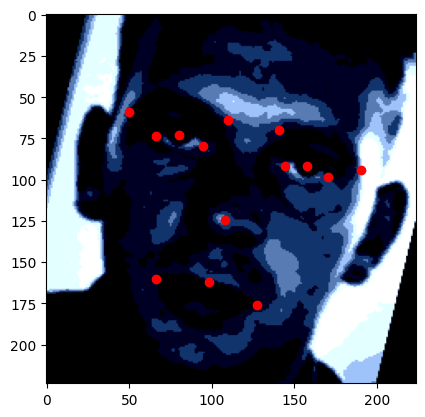

In [33]:
for idx, (X,y) in enumerate(val_dataloader_aug):
    print(X.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    for i in range(0,28,2):
        plt.scatter(y[0,i],y[0,i+1],c = "r")
    break

torch.Size([3, 224, 224])
tensor([151.0363,  83.8174,  63.6535,  97.7043, 131.7318,  87.6919, 172.2783,
         86.4889,  80.2528,  95.9506,  48.0411, 106.0761, 126.7251,  53.6528,
        180.2501,  65.7949,  77.4033,  65.0926,  27.6409,  95.6907, 111.9137,
        109.7734, 162.2175, 167.1053,  80.9774, 180.0420, 118.0163, 145.6406,
        123.8631, 190.6112], dtype=torch.float64)


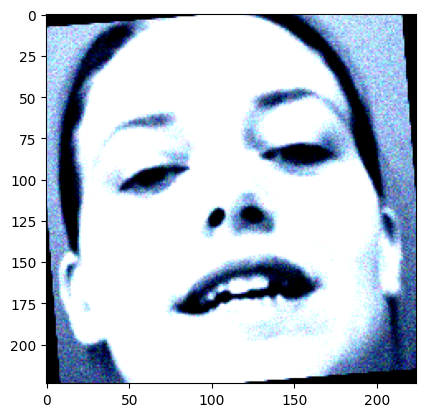

In [34]:
example,label = next(iter(val_dataloader_aug))#[0][56]
example = example[56]
label = label[56]
plt.imshow(example.permute(1,2,0), cmap= 'gray')
print(example.shape)
print(label)

In [28]:
def make_predictions(model: torch.nn.Module, img: torch.Tensor, device = 'cpu'):
    
    #If image is custom, apply needed transformations here, like resizing and addition of
    #color channels (if image is black and white)
    
    model.eval()
    with torch.inference_mode():
        preds = model(img.unsqueeze(0).to(device)) # Add the batch dimension to the single sample
        preds = torch.clip(preds,0,224)
        
    return preds

tensor([156.4957,  85.8954,  68.8645,  87.0797, 136.5087,  88.4266, 167.0505,
         87.7231,  85.2667,  88.5912,  52.2876,  88.7301, 129.5397,  68.7011,
        179.0236,  69.4446,  91.2437,  69.1982,  37.1522,  71.3084, 113.0526,
        144.0620, 145.8382, 172.0515,  76.6970, 172.8212, 111.3335, 165.8993,
        113.6611, 188.8173], device='cuda:0')


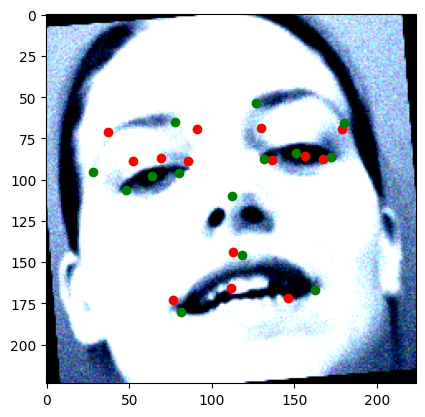

In [39]:
preds = make_predictions(model= loaded_model,
                         img= example,
                         device= device)

preds = preds.squeeze()
preds_array = np.array(preds.to('cpu'))

plt.imshow(example.permute(1,2,0), cmap= 'gray')
    
for i in range(0,28,2):
    plt.scatter(preds_array[i],preds_array[i+1],c = "r")
    
for i in range(0,28,2):
    plt.scatter(label[i],label[i+1],c = "g")
    
print(preds)

## It seems to struggle with faces in non-conventional positions, like rotated and tilted faces... --> Maybe augment data with more rotations, and train for longer??

# Test with custom image

In [55]:
from PIL import Image

def convert_image(file_path) -> torch.Tensor:
    
    img_custom = Image.open(file_path)
    img_custom = np.array(img_custom)
    
    custom_transform = A.Compose(
        [
            A.ToGray(p=1),
            #A.CenterCrop(height=500, width=500),
            A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, p=1),
            A.Resize(width=224, height=224),
            A.ShiftScaleRotate(shift_limit=0, scale_limit=0.5, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255,
            ),
            ToTensorV2(),
        ]
    )


    custom = custom_transform(image = img_custom)
    
    return custom['image']
    

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

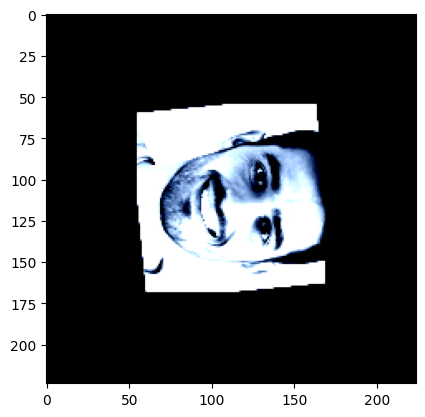

In [67]:
custom_image = convert_image("/kaggle/input/facial-keypoint-detection-custom/custom_3.jpg")

plt.figure()
plt.imshow(custom_image.permute(1,2,0))

print(custom_image)

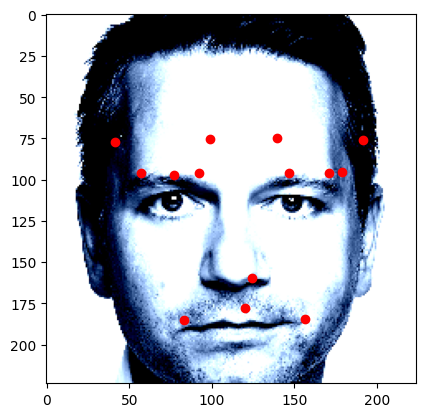

In [42]:
preds = make_predictions(model= loaded_model,
                         img= custom_image,
                         device= device)

preds = preds.squeeze()
preds_array = np.array(preds.to('cpu'))

plt.imshow(custom_image.permute(1,2,0), cmap= 'gray')
    
for i in range(0,28,2):
    plt.scatter(preds_array[i],preds_array[i+1],c = "r")

# Try to improve model

In [38]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Data augmentation for images
train_transforms_extrem_aug = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        #A.IAAAffine(shear=15, scale=1.0, mode="constant", p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.2, rotate_limit=0, p=0.8, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [39]:
train_dataset_extrem_aug = DatasetGenerator(df_train, transform= train_transforms_extrem_aug)
val_dataset_extrem_aug = DatasetGenerator(df_val, transform= train_transforms_extrem_aug)

In [40]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader_extrem_aug = DataLoader(dataset=train_dataset_extrem_aug, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader_extrem_aug = DataLoader(dataset=val_dataset_extrem_aug, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

torch.Size([64, 3, 224, 224])


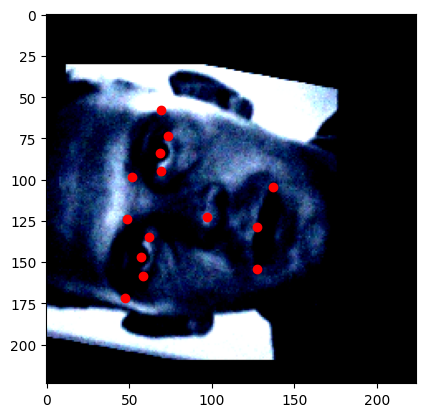

In [41]:
for idx, (X,y) in enumerate(val_dataloader_extrem_aug):
    print(X.shape)
    plt.imshow(X[0].permute(1,2,0), cmap= 'gray')
    
    for i in range(0,28,2):
        plt.scatter(y[0,i],y[0,i+1],c = "r")
    break

In [49]:
# Load previously trained model
model_4 = torchvision.models.efficientnet_b0(weights=None).to(device)
model_4.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)

model_4.load_state_dict(torch.load(f="/kaggle/working/models/EffNet_Augmentation_100Epochs.pth"))
model_4.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn_4 = nn.MSELoss(reduction="sum")

In [51]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_4 = train(model=model_4,
            train_dataloader=train_dataloader_extrem_aug,
            test_dataloader=val_dataloader_extrem_aug,
            optimizer=optimizer_4,
            loss_fn=loss_fn_4,
            epochs=50,
            device=device,
            save_freq=10,
            save_name = "EffNet_Extrem_Augmentation_50Epochs")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2481.4495 | test_loss: 2277.7790 | 
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 2154.6468 | test_loss: 1940.2204 | 
Epoch: 3 | train_loss: 1882.4728 | test_loss: 1756.2281 | 
Epoch: 4 | train_loss: 1663.0420 | test_loss: 1611.1071 | 
Epoch: 5 | train_loss: 1554.9090 | test_loss: 1448.4030 | 
Epoch: 6 | train_loss: 1413.1595 | test_loss: 1289.9505 | 
Epoch: 7 | train_loss: 1276.1415 | test_loss: 1185.6419 | 
Epoch: 8 | train_loss: 1193.0678 | test_loss: 1141.6116 | 
Epoch: 9 | train_loss: 1116.9717 | test_loss: 1052.6965 | 
Epoch: 10 | train_loss: 1078.3491 | test_loss: 1002.3084 | 
Epoch: 11 | train_loss: 978.1167 | test_loss: 971.0309 | 
Epoch: 11 | Saving model
Epoch: 12 | train_loss: 972.2493 | test_loss: 935.7757 | 
Epoch: 13 | train_loss: 989.2431 | test_loss: 919.3123 | 
Epoch: 14 | train_loss: 952.7586 | test_loss: 870.0071 | 
Epoch: 15 | train_loss: 955.8292 | test_loss: 879.9324 | 
Epoch: 16 | train_loss: 926.3293 | test_loss: 870.1403 | 
Epoch: 17 | 

In [52]:
torch.save(obj=model_4.state_dict(), # only saving the state_dict() only saves the learned parameters
           f="/kaggle/working/models/EffNet_Extreme_Augmentation_Final.pth")

In [42]:
#Load chosen model
loaded_model = torchvision.models.efficientnet_b0(weights=None).to(device)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load(f="/kaggle/working/models/EffNet_Extreme_Augmentation_Final.pth"))
loaded_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

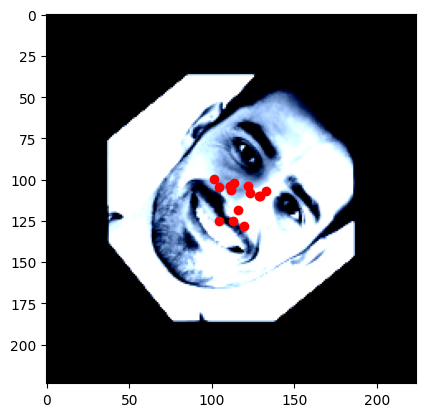

In [77]:
custom_image = convert_image("/kaggle/input/facial-keypoint-detection-custom/custom_3.jpg")

preds = make_predictions(model= loaded_model,
                         img= custom_image,
                         device= device)

preds = preds.squeeze()
preds_array = np.array(preds.to('cpu'))

plt.imshow(custom_image.permute(1,2,0), cmap= 'gray')
    
for i in range(0,28,2):
    plt.scatter(preds_array[i],preds_array[i+1],c = "r")

The model is working very well for unseen images in any position. It still seems to have problems with images where the faces are not close. --> To improve that, I could apply a transformation to have faces at different distances, and redo the training.

# Problem with size correction

In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Data augmentation for images
train_transforms_extrem_size_aug = A.Compose(
    [
        A.Resize(width=224, height=224),
        A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        #A.IAAAffine(shear=15, scale=1.0, mode="constant", p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.12, scale_limit=0.6, rotate_limit=0, p=0.8, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

In [31]:
train_dataset_extrem_size_aug = DatasetGenerator(df_train, transform= train_transforms_extrem_size_aug)
val_dataset_extrem_size_aug = DatasetGenerator(df_val, transform= train_transforms_extrem_size_aug)

In [32]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader_extrem_size_aug = DataLoader(dataset=train_dataset_extrem_size_aug, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

val_dataloader_extrem_size_aug = DataLoader(dataset=val_dataset_extrem_size_aug, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

In [82]:
# Load previously trained model
model_5 = torchvision.models.efficientnet_b0(weights=None).to(device)
model_5.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)

model_5.load_state_dict(torch.load(f="/kaggle/working/models/EffNet_Extreme_Augmentation_Final.pth"))
model_5.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [33]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn_5 = nn.MSELoss(reduction="sum")

NameError: name 'model_5' is not defined

In [84]:
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results

results_5 = train(model=model_5,
            train_dataloader=train_dataloader_extrem_size_aug,
            test_dataloader=val_dataloader_extrem_size_aug,
            optimizer=optimizer_5,
            loss_fn=loss_fn_5,
            epochs=11,
            device=device,
            save_freq=10,
            save_name = "EffNet_Extrem_Size_Augmentation_10Epochs")

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 198.0562 | test_loss: 135.0197 | 
Epoch: 1 | Saving model
Epoch: 2 | train_loss: 182.3130 | test_loss: 142.7068 | 
Epoch: 3 | train_loss: 174.2650 | test_loss: 138.4458 | 
Epoch: 4 | train_loss: 161.0914 | test_loss: 118.8931 | 
Epoch: 5 | train_loss: 158.2122 | test_loss: 99.7988 | 
Epoch: 6 | train_loss: 151.4617 | test_loss: 114.7238 | 
Epoch: 7 | train_loss: 152.0408 | test_loss: 99.3429 | 
Epoch: 8 | train_loss: 151.0547 | test_loss: 95.4898 | 
Epoch: 9 | train_loss: 152.1627 | test_loss: 88.6998 | 
Epoch: 10 | train_loss: 132.4076 | test_loss: 87.6066 | 
Epoch: 11 | train_loss: 138.3419 | test_loss: 101.0369 | 
Epoch: 11 | Saving model
[INFO] Total training time: 1412.652 seconds


In [35]:
#Load chosen model
loaded_model = torchvision.models.efficientnet_b0(weights=None).to(device)
loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=30, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load(f="/kaggle/working/models/EffNet_Extrem_Size_Augmentation_10Epochs.pth"))
loaded_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

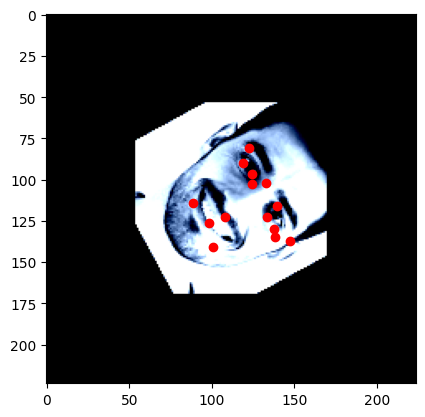

In [49]:
custom_image = convert_image("/kaggle/input/facial-keypoint-detection-custom/custom_3.jpg")

preds = make_predictions(model= loaded_model,
                         img= custom_image,
                         device= device)

preds = preds.squeeze()
preds_array = np.array(preds.to('cpu'))

plt.imshow(custom_image.permute(1,2,0), cmap= 'gray')
    
for i in range(0,28,2):
    plt.scatter(preds_array[i],preds_array[i+1],c = "r")

Problem solved --> Model is working in a satisfying manner.

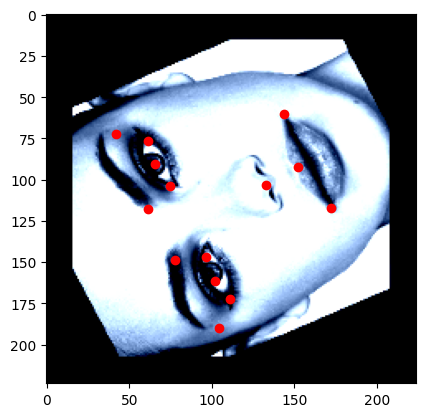

In [60]:
custom_image = convert_image("/kaggle/input/facial-keypoint-detection-custom/custom_5.jpg")

preds = make_predictions(model= loaded_model,
                         img= custom_image,
                         device= device)

preds = preds.squeeze()
preds_array = np.array(preds.to('cpu'))

plt.imshow(custom_image.permute(1,2,0), cmap= 'gray')
    
for i in range(0,28,2):
    plt.scatter(preds_array[i],preds_array[i+1],c = "r")

Lessons learned:

- How to set up a model for image regression
- How to use albumentations for data augmentation
- The importance of data augmentation and the impact of different types of techniques on the end result
- How to assess the performance of the model, find the reasons for the observed behavior and problems, and implement strategies to improve it (such as augmentating data in way to make the model improve on those specific problems)
- Incrementrally improve the model in different training rounds, assessing the performance and correcting problems, is a good way of approaching a problem.